In [386]:
%run constants.ipynb
%run dataloaders.ipynb
%run utils.ipynb
%run prior.ipynb
%run models.ipynb
%run coresets.ipynb
%run train_and_test.ipynb
%run config.ipynb

In [379]:
from copy import deepcopy

In [380]:
def run_experiment_for(model, print_progress=False):
    config = model.config
    dataloaders = config.dataloaders
    coreset_alg = config.coreset_alg
    assert coreset_alg is None or coreset_alg.coresets == []  # should initially be empty
    results = np.zeros((len(config.tasks), len(config.tasks)))
    results_std = np.zeros((len(config.tasks), len(config.tasks)))
    is_vcl = isinstance(model, VCLNN)
    
    # Train and evaluate
    for task_id in range(len(config.tasks)):
        print_if(f"\nTraining on Task {task_id+1} ...", print_progress)
        train_loader, _ = dataloaders[task_id]
        # Train on non-coreset data
        train(model, train_loader, task_id)
        print_if(f"... Finished training on Task {task_id+1}", print_progress)
        
        # Train on new coreset
        if is_vcl and coreset_alg is not None and config.coreset_size > 0:  # VCL models with coresets
            coreset_alg.add_coreset(train_loader)
            # Train on coresets from previous tasks
            for prev_task in range(task_id+1):
                print_if(f"\nRe-training on Task {prev_task+1} ...", print_progress)
                train(model, coreset_alg.coresets[prev_task], prev_task)
        print_if('', print_progress)
        
        # Evaluate on previous tasks
        for curr_t in range(task_id+1):
            _, test_loader = dataloaders[curr_t]
            score, std = test(model, test_loader, curr_t, ret_std=True)
            print_if(f"Task {(curr_t+1):2d}  {config.eval_metric}: \
                        {np.round(score, 4):0.4f} ± {np.round(std, 4):0.4f}", print_progress)
            results[task_id, curr_t] = score
            results_std[task_id, curr_t] = std
        print_if('', print_progress)

        if is_vcl and config.update_prior:  # update prior for VCL models
            model.update_priors()
            
    return results, results_std

In [381]:
def run_experiment_multi(configs=None, task_type='classification', config_filter=None,
                         init_prior_scale=0.1, coreset_sizes=[100,200], 
                         print_progress=False, ret_std=True, show_vanilla=True):
    """Run complete VCL experiment"""
    if configs is None:
        configs = get_all_configs(task_type, config_filter,
                                  init_prior_scale, coreset_sizes)
    # Initialize models
    models = {c.name: VCLNN(c).to(DEVICE) for c in configs}
    if show_vanilla:
        vanillaNN = VanillaNN(ExperimentConfig()).to(DEVICE) 
        models[VANILLA_MODEL] = vanillaNN

    results = {}
    results_std = {}
    for model_name, model in models.items():
        res, res_std = run_experiment_for(model, print_progress=print_progress)
        results[model_name] = res
        results_std[model_name] = res_std
    return results if not ret_std else (results, results_std)

# Compare the basic models, with random coreset of size 200

In [382]:
torch.manual_seed(888)
np.random.seed(777)
configs = get_all_configs('classification', config_filter=(lambda c: c.coreset_alg_name == 'random' and \
                                                           c.coreset_size == 200))
cmp_prior_cla_results, cmp_prior_cla_results_std = run_experiment_multi(configs=configs)

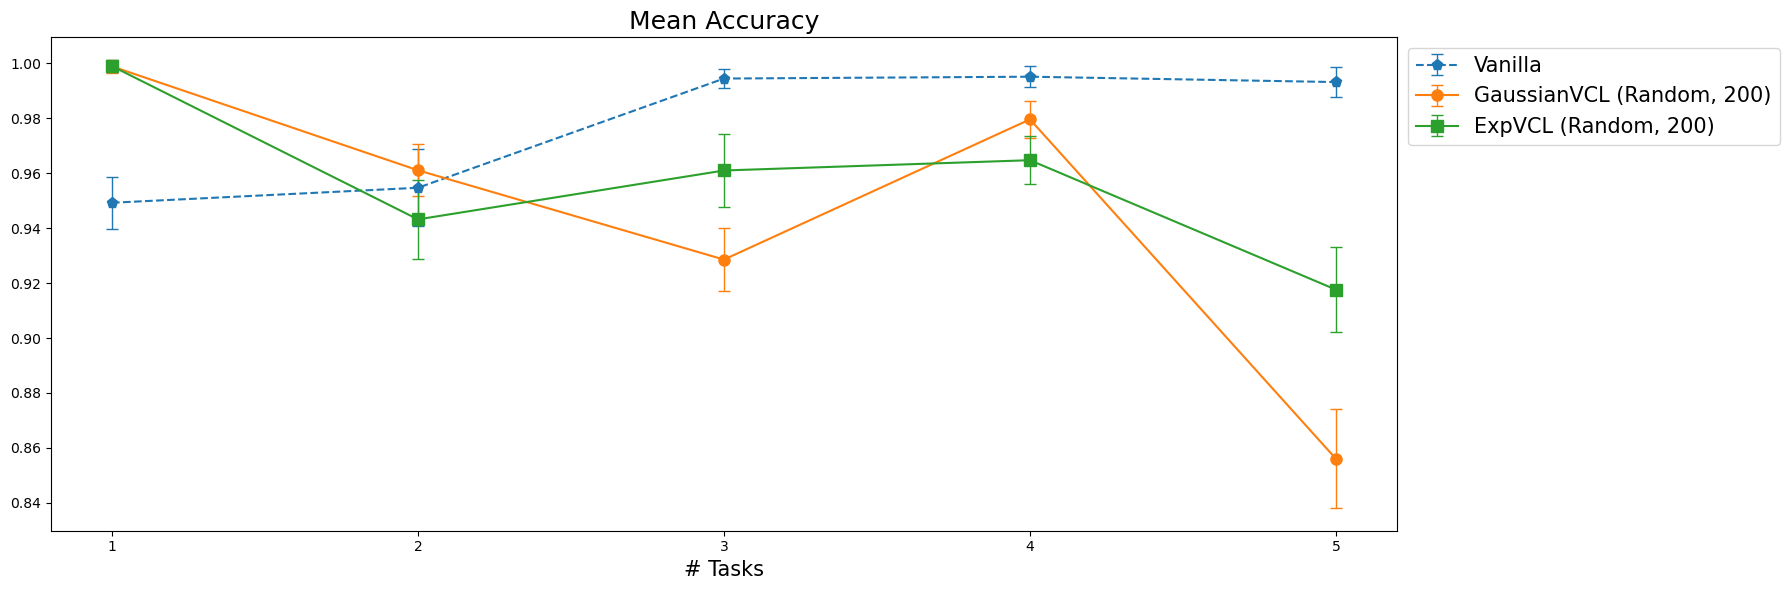

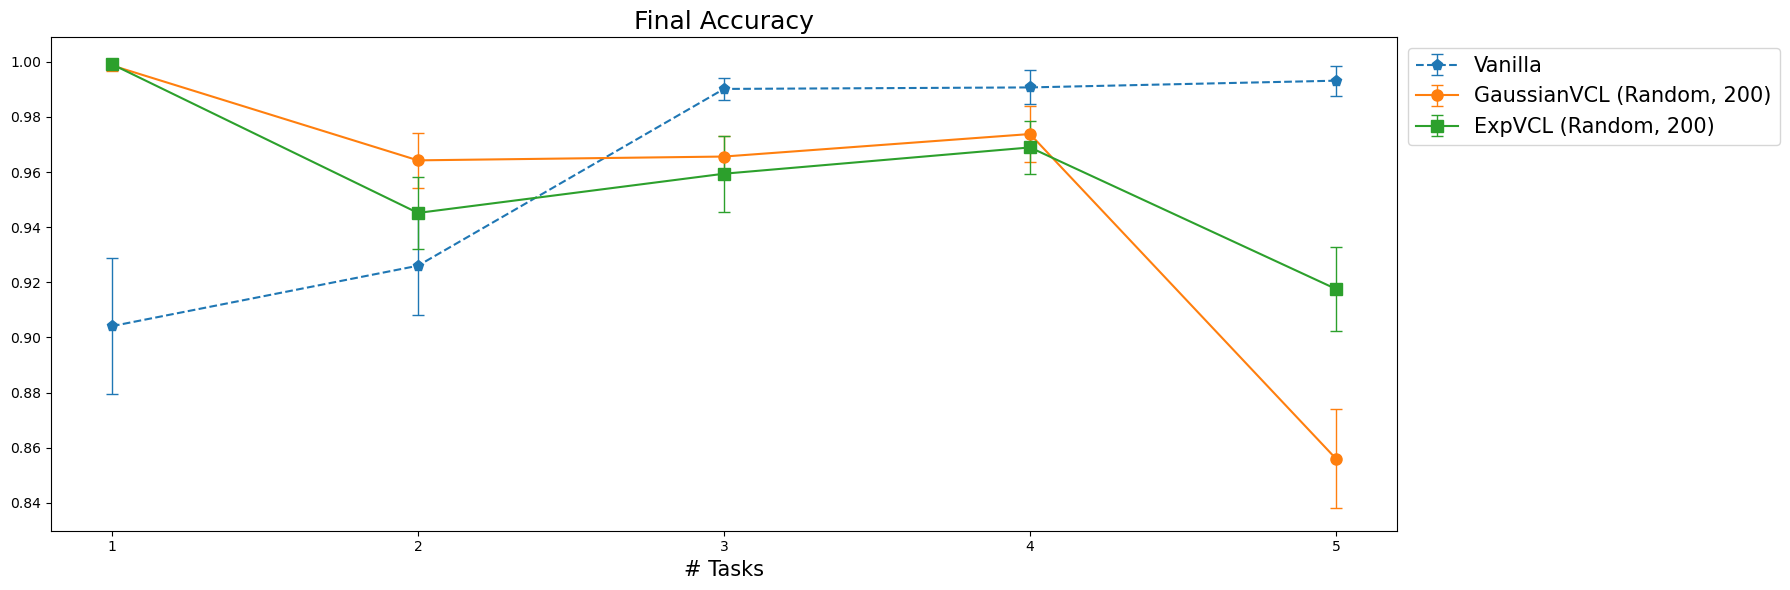

In [383]:
plot_mean_results(ExperimentConfig('classification'), cmp_prior_cla_results, results_std=cmp_prior_cla_results_std)
plot_final_results(ExperimentConfig('classification'), cmp_prior_cla_results, results_std=cmp_prior_cla_results_std)

In [288]:
cmp_prior_cla_results

{'GaussianVCL (Random, 200)': array([[0.9979076 , 0.        , 0.        , 0.        , 0.        ],
        [0.99956597, 0.96178515, 0.        , 0.        , 0.        ],
        [0.99956597, 0.96473828, 0.9298185 , 0.        , 0.        ],
        [0.99913194, 0.95639063, 0.92927068, 0.99007833, 0.        ],
        [0.99913194, 0.95450781, 0.9661895 , 0.99041056, 0.82571683]]),
 'ExpGaussianVCL (Random, 200)': array([[0.99869792, 0.        , 0.        , 0.        , 0.        ],
        [0.99869792, 0.93837109, 0.        , 0.        , 0.        ],
        [0.99869792, 0.94474219, 0.96765435, 0.        , 0.        ],
        [0.99913194, 0.94761328, 0.96015149, 0.9629309 , 0.        ],
        [0.99913194, 0.94217187, 0.95972275, 0.97304889, 0.93079955]]),
 'ExpVCL (Random, 200)': array([[0.99565972, 0.        , 0.        , 0.        , 0.        ],
        [0.99826389, 0.99019922, 0.        , 0.        , 0.        ],
        [0.99652778, 0.90888672, 0.99304497, 0.        , 0.        ],
 

In [384]:
torch.manual_seed(888)
np.random.seed(777)
configs = get_all_configs('regression', config_filter=(lambda c: c.coreset_alg_name == 'random' and \
                                                           c.coreset_size == 200))
cmp_prior_reg_results, cmp_prior_reg_results_std = run_experiment_multi(configs, task_type='regression')

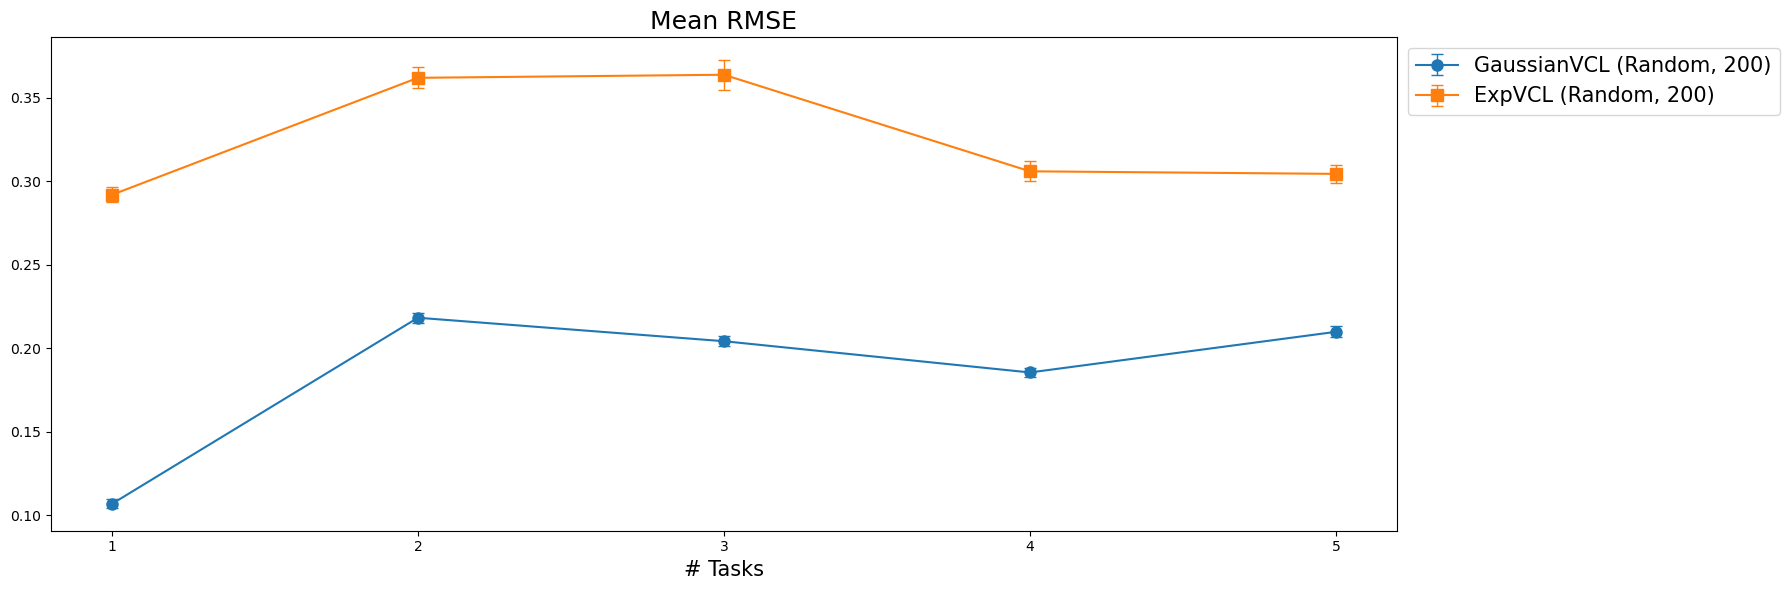

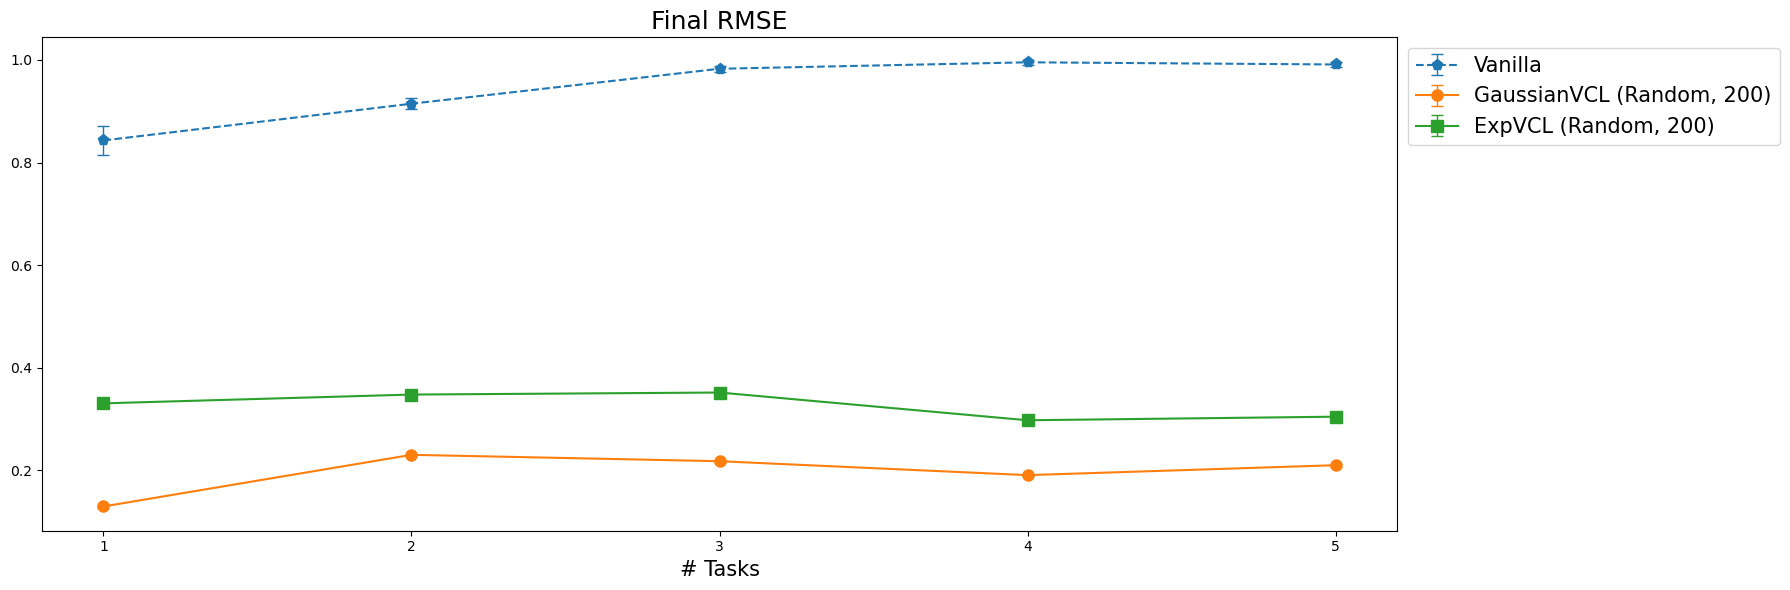

In [385]:
plot_mean_results(configs[0], cmp_prior_reg_results, results_std=cmp_prior_reg_results_std, 
                  mname_filter=(lambda m: m != VANILLA_MODEL))
plot_final_results(configs[0], cmp_prior_reg_results, results_std=cmp_prior_reg_results_std)

# Compare multiple changes

In [387]:
torch.manual_seed(777)
np.random.seed(888)
configs = get_all_configs('classification')
cla_all_results, cla_all_std = run_experiment_multi(configs=configs, task_type='classification')

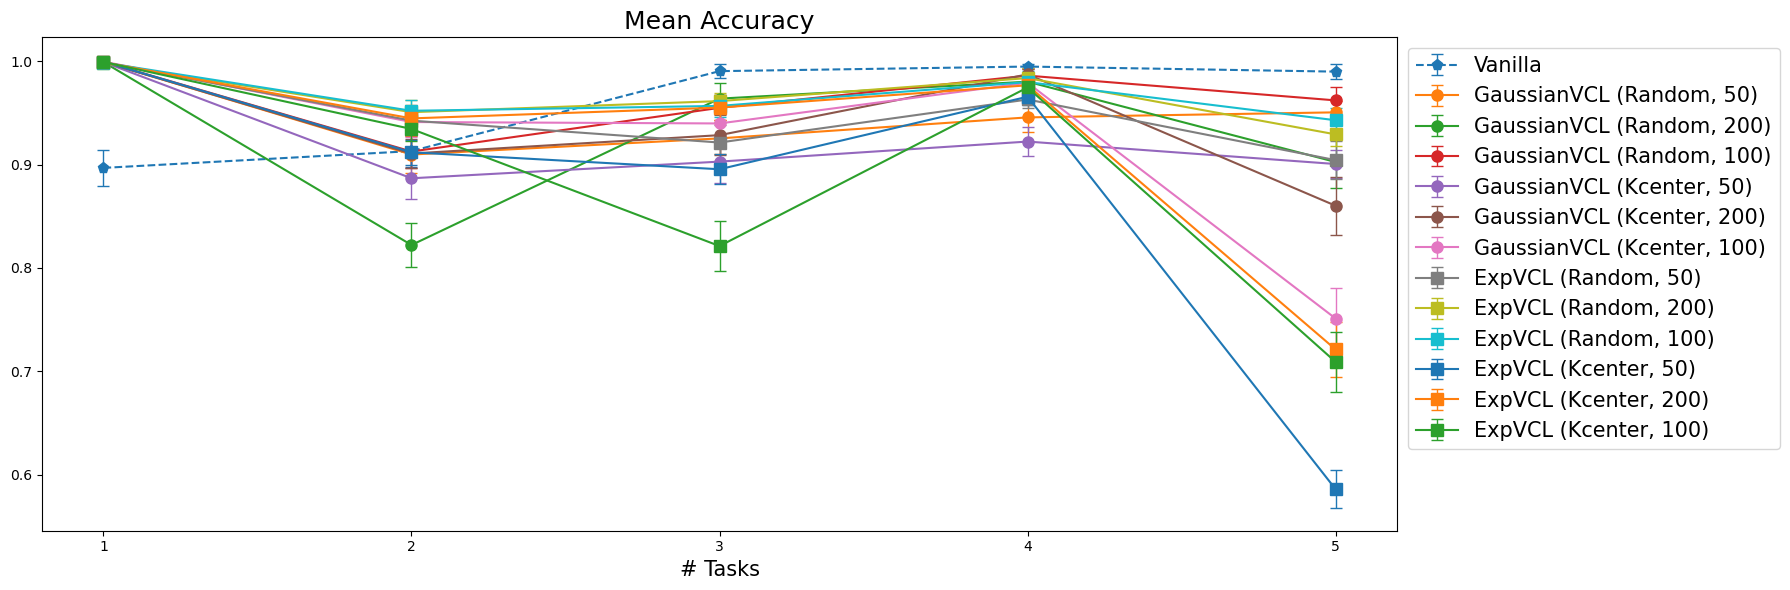

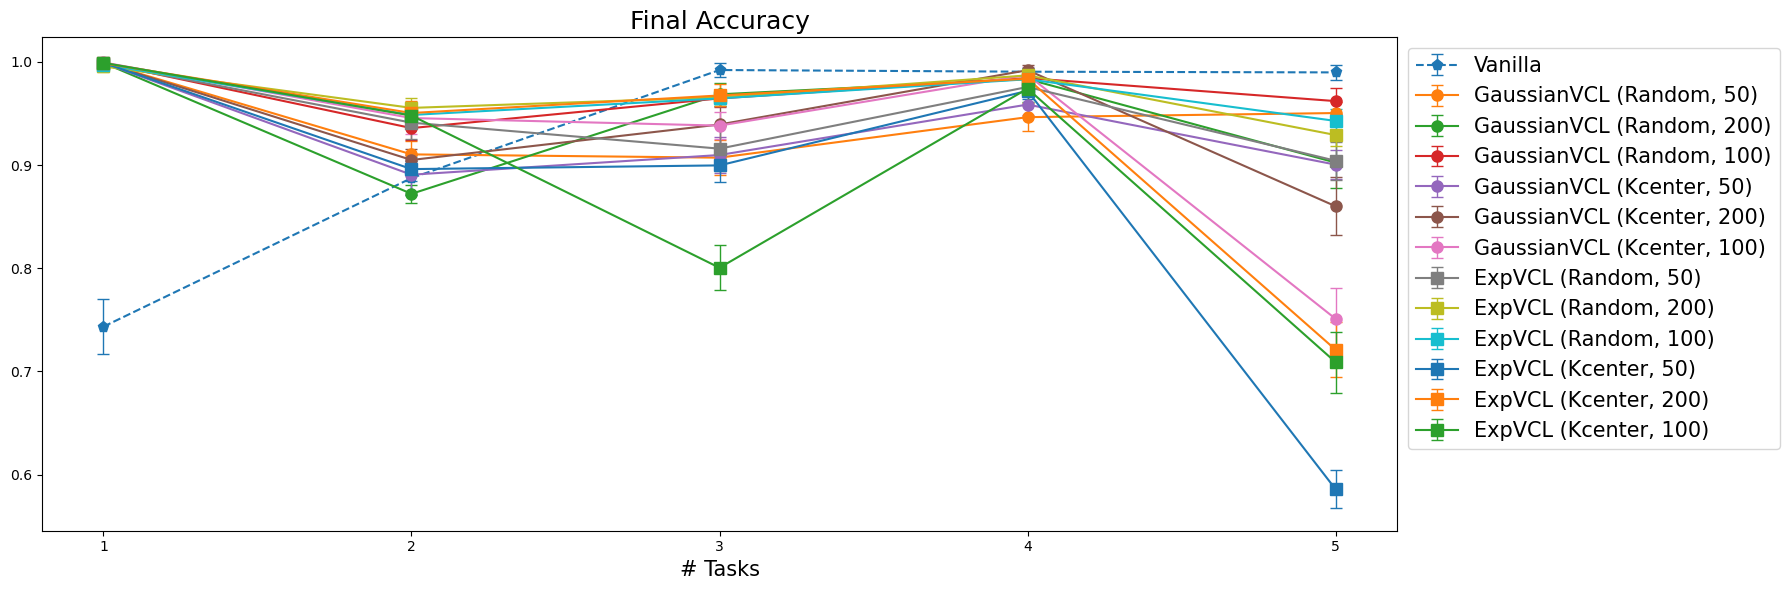

In [390]:
plot_mean_results(ExperimentConfig(task_type='classification'), 
                  cla_all_results, results_std=cla_all_std,
                  mname_filter=(lambda m : 'None' not in m))  # remove models with no coreset
plot_final_results(ExperimentConfig(task_type='classification'), 
                   cla_all_results, results_std=cla_all_std,
                   mname_filter=(lambda m : 'None' not in m))

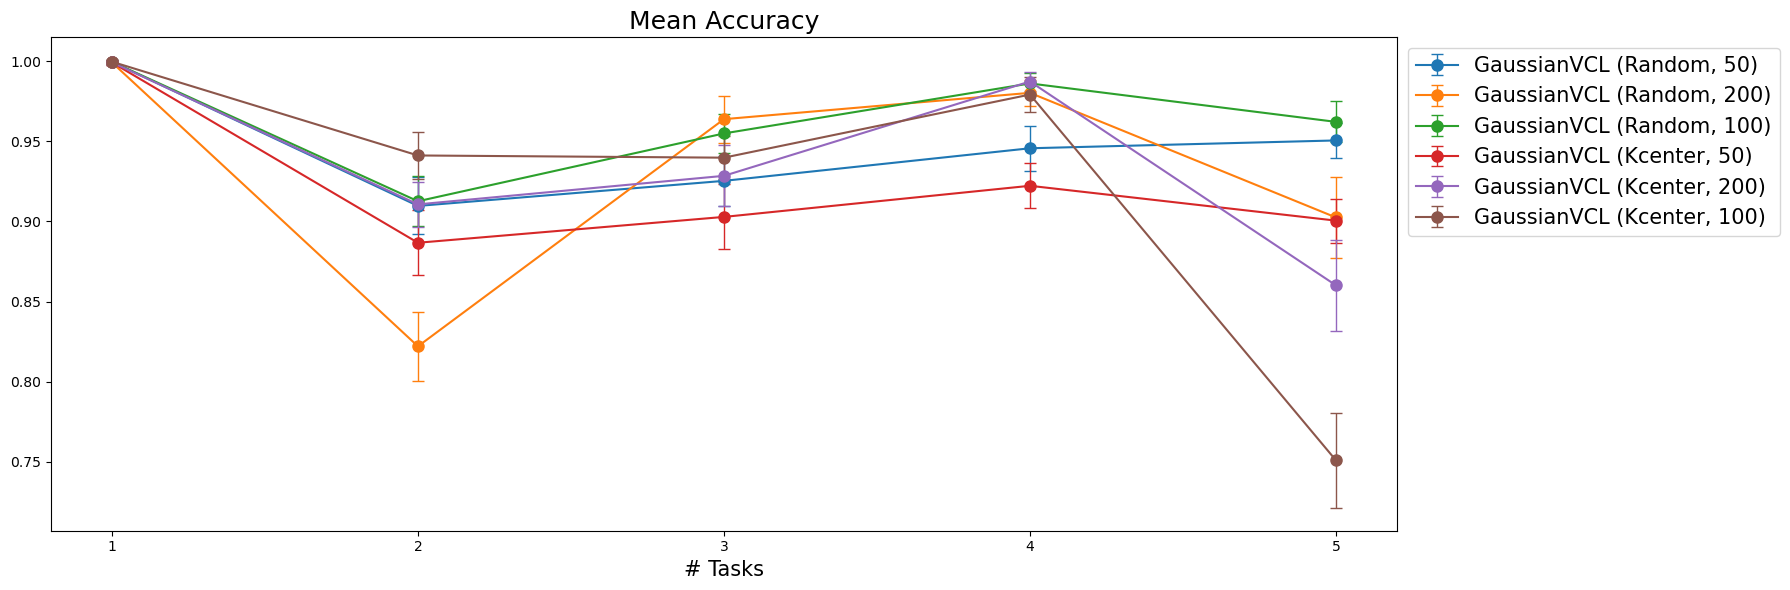

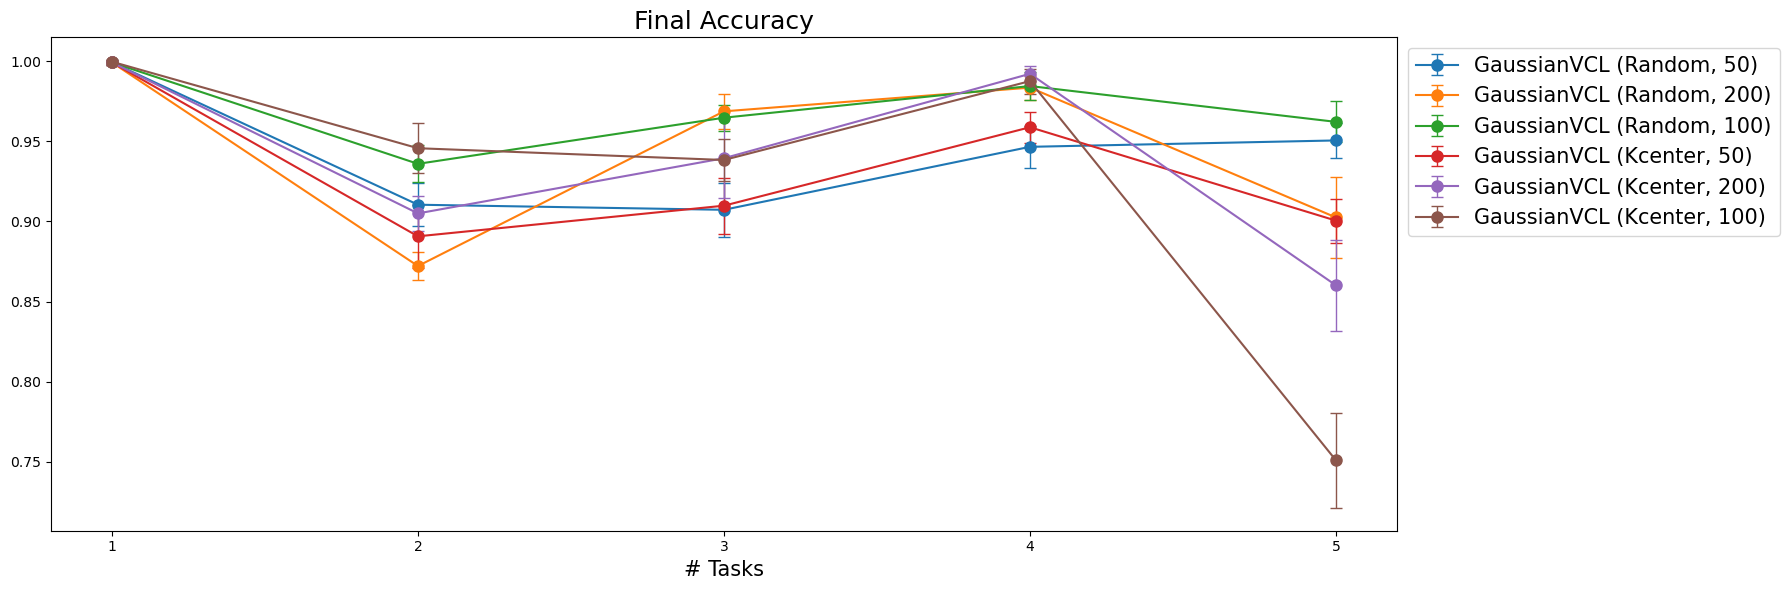

In [389]:
plot_mean_results(ExperimentConfig(task_type='classification'), 
                  cla_all_results, results_std=cla_all_std,
                  mname_filter=(lambda m : 'None' not in m and 'Gaussian' in m)) 
plot_final_results(ExperimentConfig(task_type='classification'), 
                   cla_all_results, results_std=cla_all_std,
                   mname_filter=(lambda m : 'None' not in m and 'Gaussian' in m))

In [388]:
torch.manual_seed(777)
np.random.seed(888)
configs = get_all_configs('regression')
reg_all_results, reg_all_std = run_experiment_multi(configs=configs, task_type='regression')

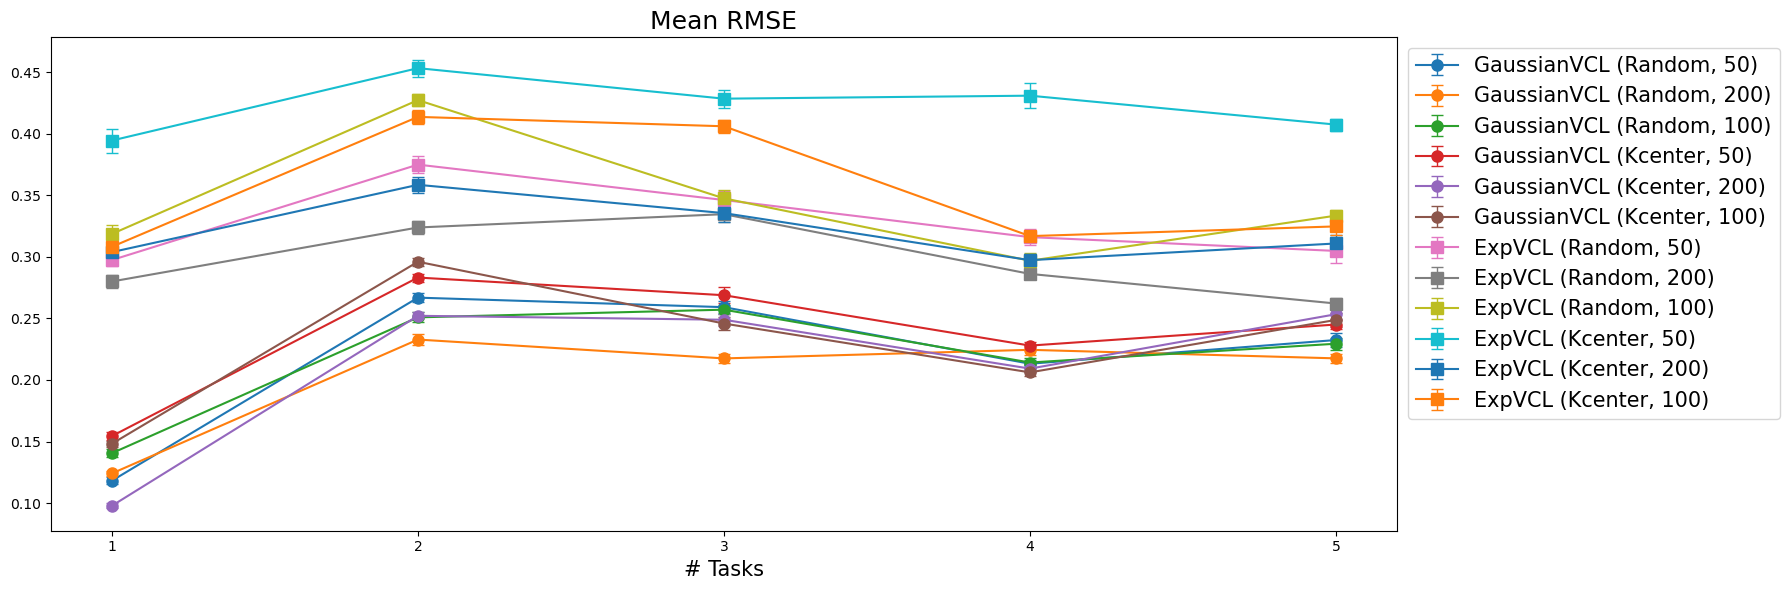

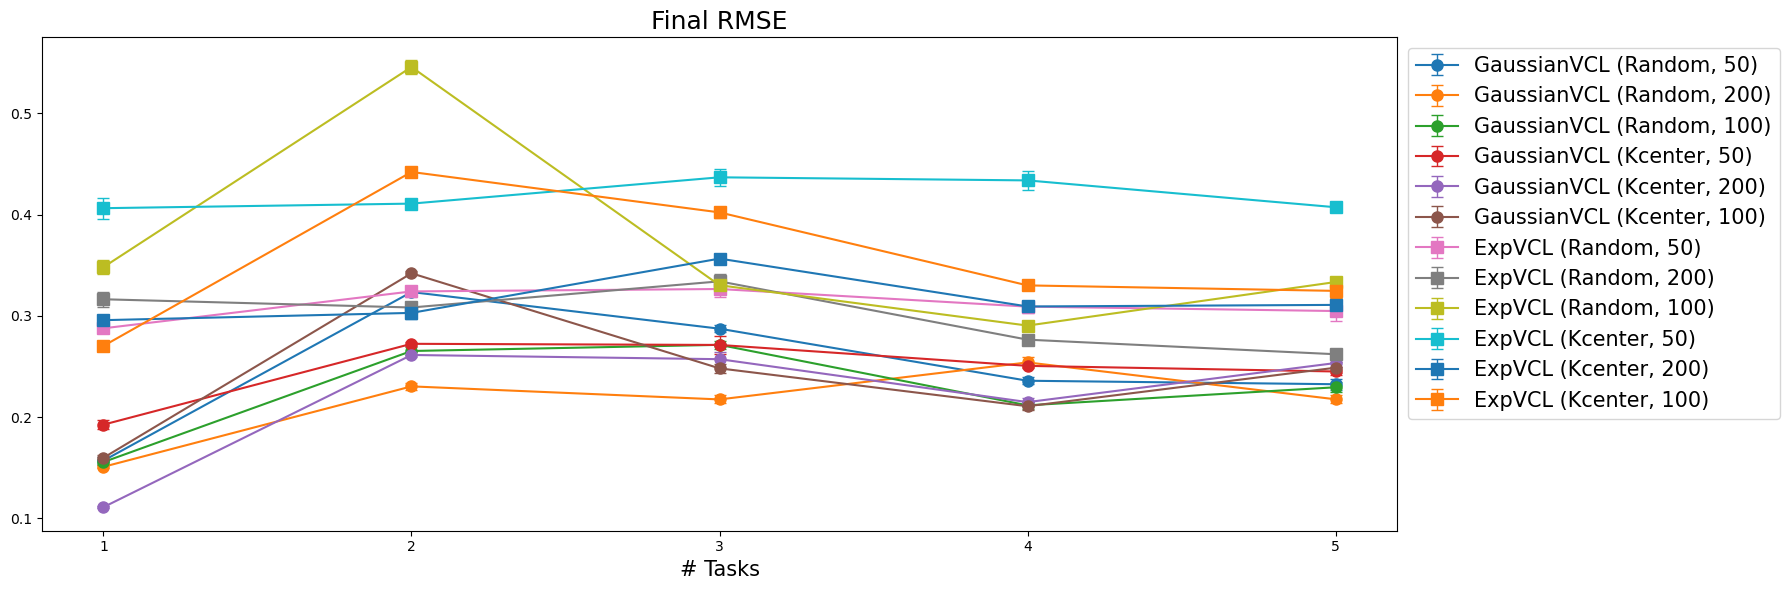

In [391]:
plot_mean_results(ExperimentConfig(task_type='regression'), reg_all_results, results_std=reg_all_std,
                 mname_filter=(lambda m : 'None' not in m and m != VANILLA_MODEL and 'ExpGaussian' not in m))
plot_final_results(ExperimentConfig(task_type='regression'), reg_all_results, results_std=reg_all_std,
                  mname_filter=(lambda m : 'None' not in m and m != VANILLA_MODEL))

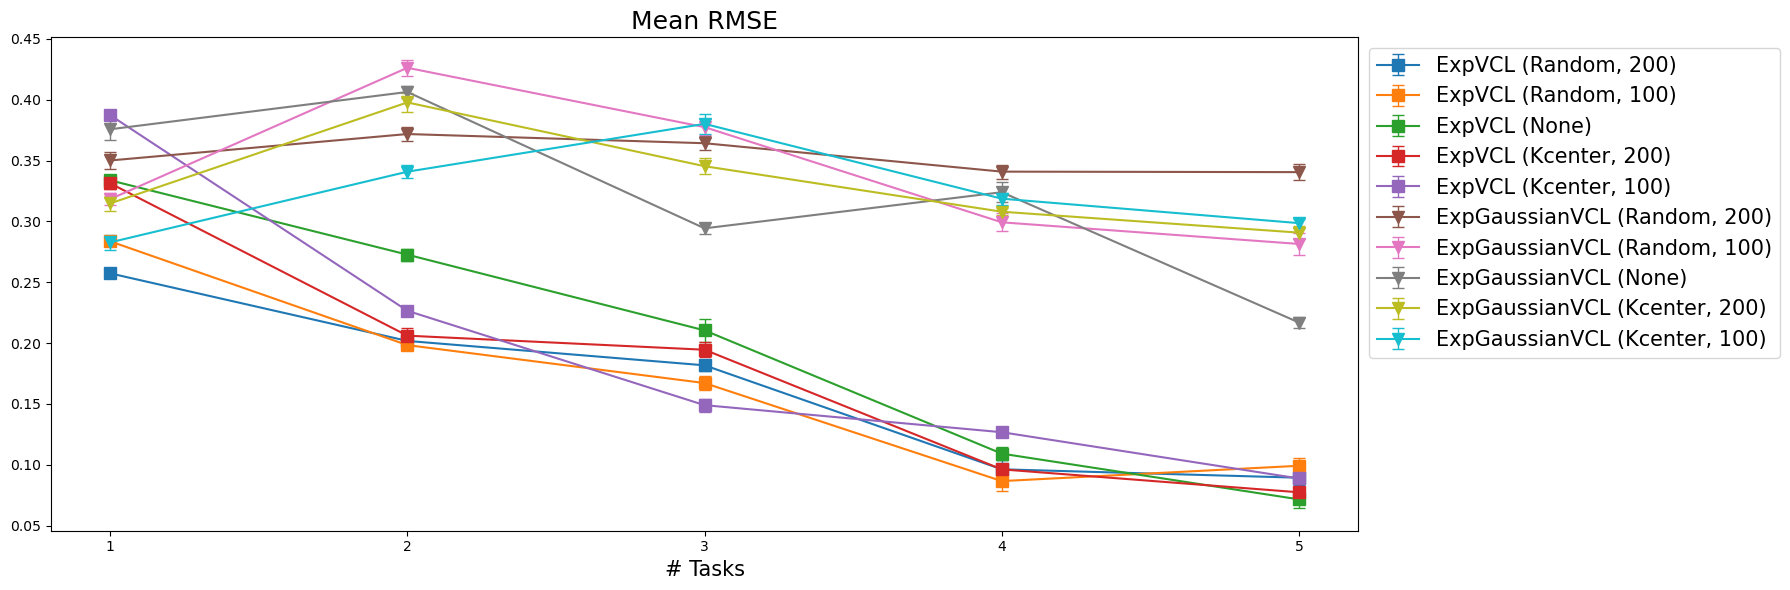

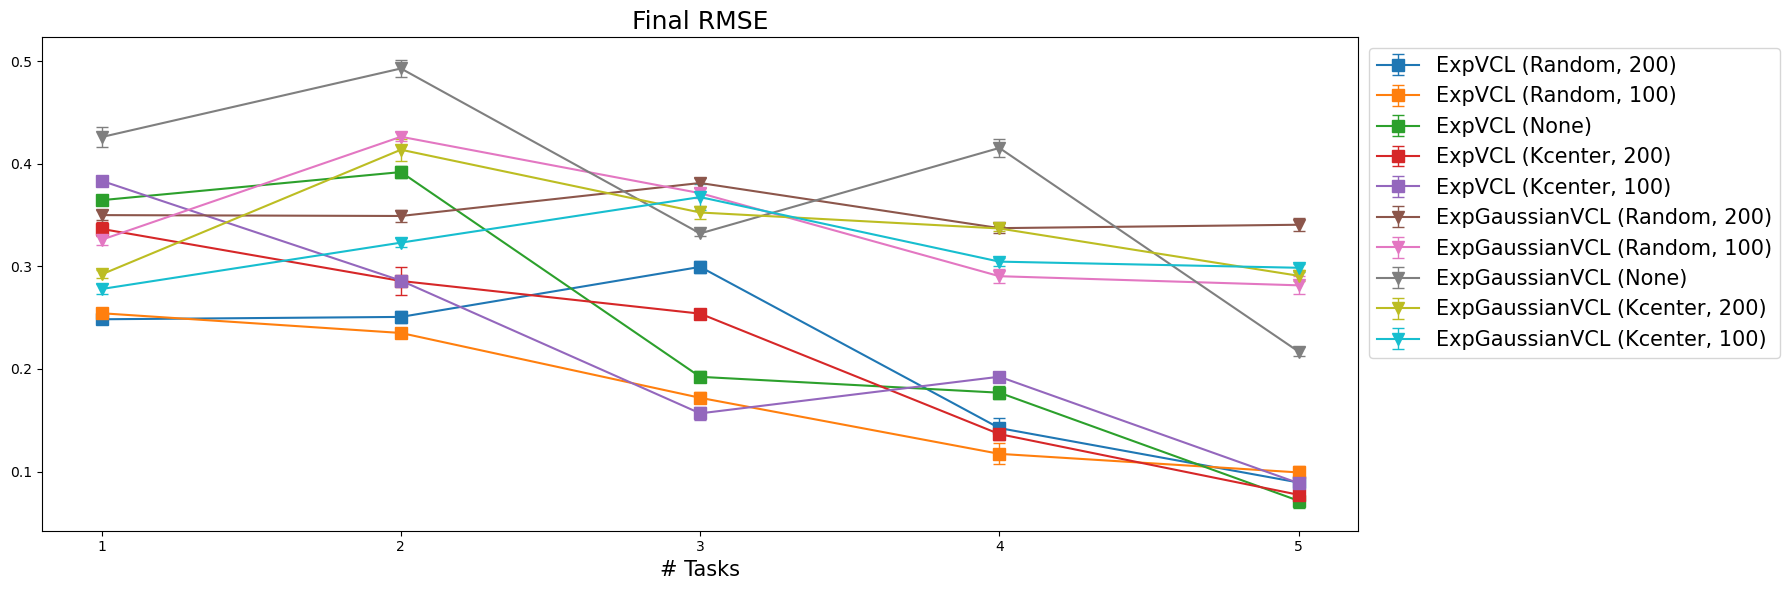

In [353]:
# Compare Exp and ExpGaussian VCL
plot_mean_results(ExperimentConfig(task_type='regression'), reg_all_results, results_std=reg_all_std,
                 mname_filter=(lambda m : 'Exp' in m))
plot_final_results(ExperimentConfig(task_type='regression'), reg_all_results, results_std=reg_all_std,
                  mname_filter=(lambda m : 'Exp' in m))

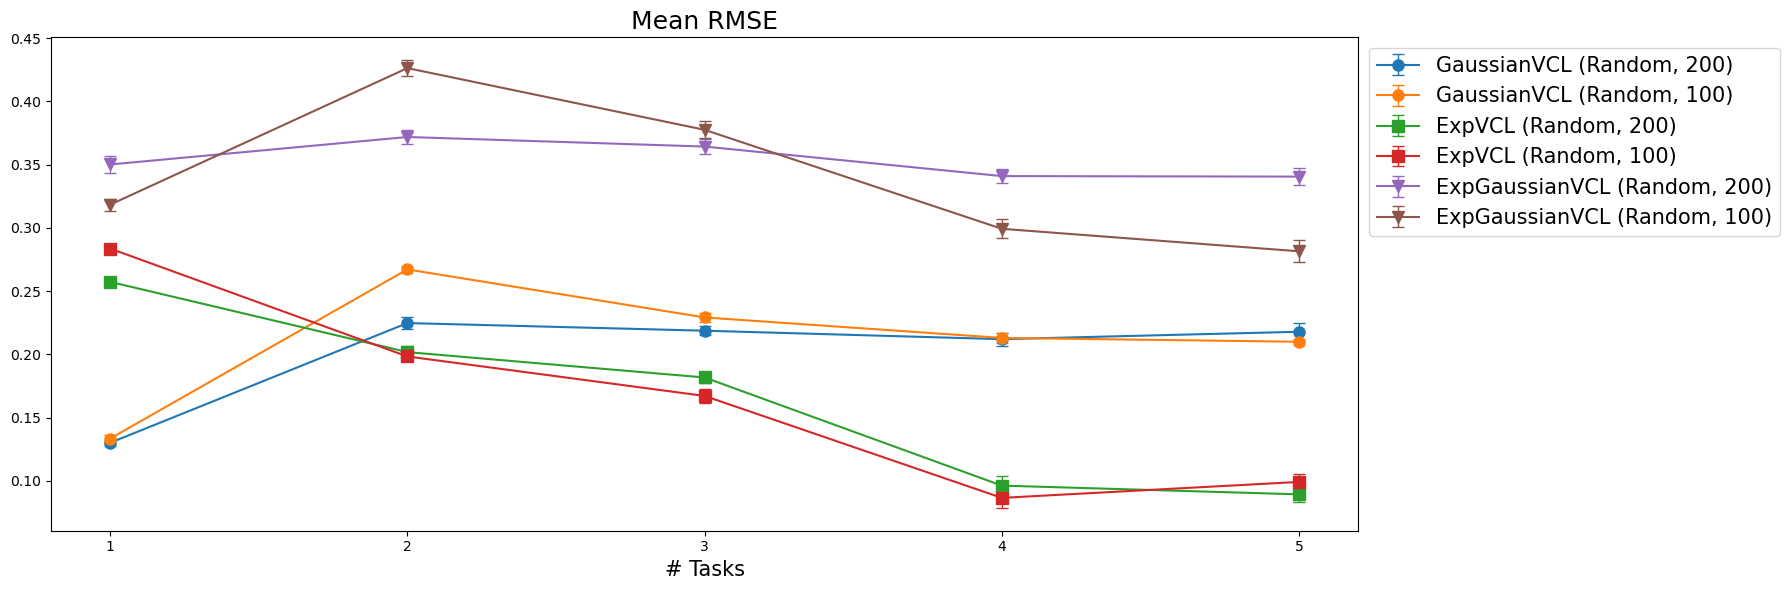

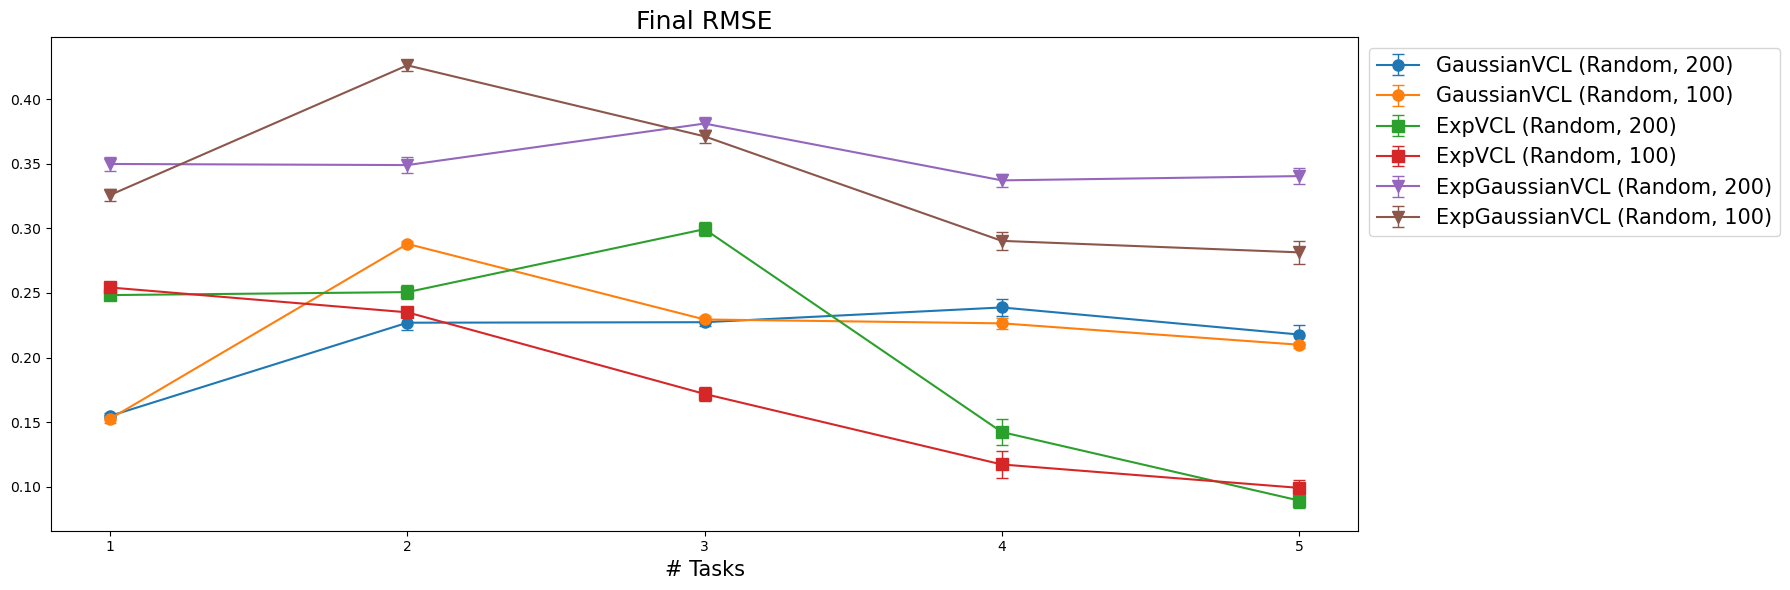

In [345]:
# Compare different coreset sizes for Random coreset
plot_mean_results(ExperimentConfig(task_type='regression'), reg_all_results, results_std=reg_all_std,
                 mname_filter=(lambda m : 'None' not in m and m != VANILLA_MODEL and 'Random' in m))
plot_final_results(ExperimentConfig(task_type='regression'), reg_all_results, results_std=reg_all_std,
                  mname_filter=(lambda m : 'None' not in m and m != VANILLA_MODEL and 'Random' in m))

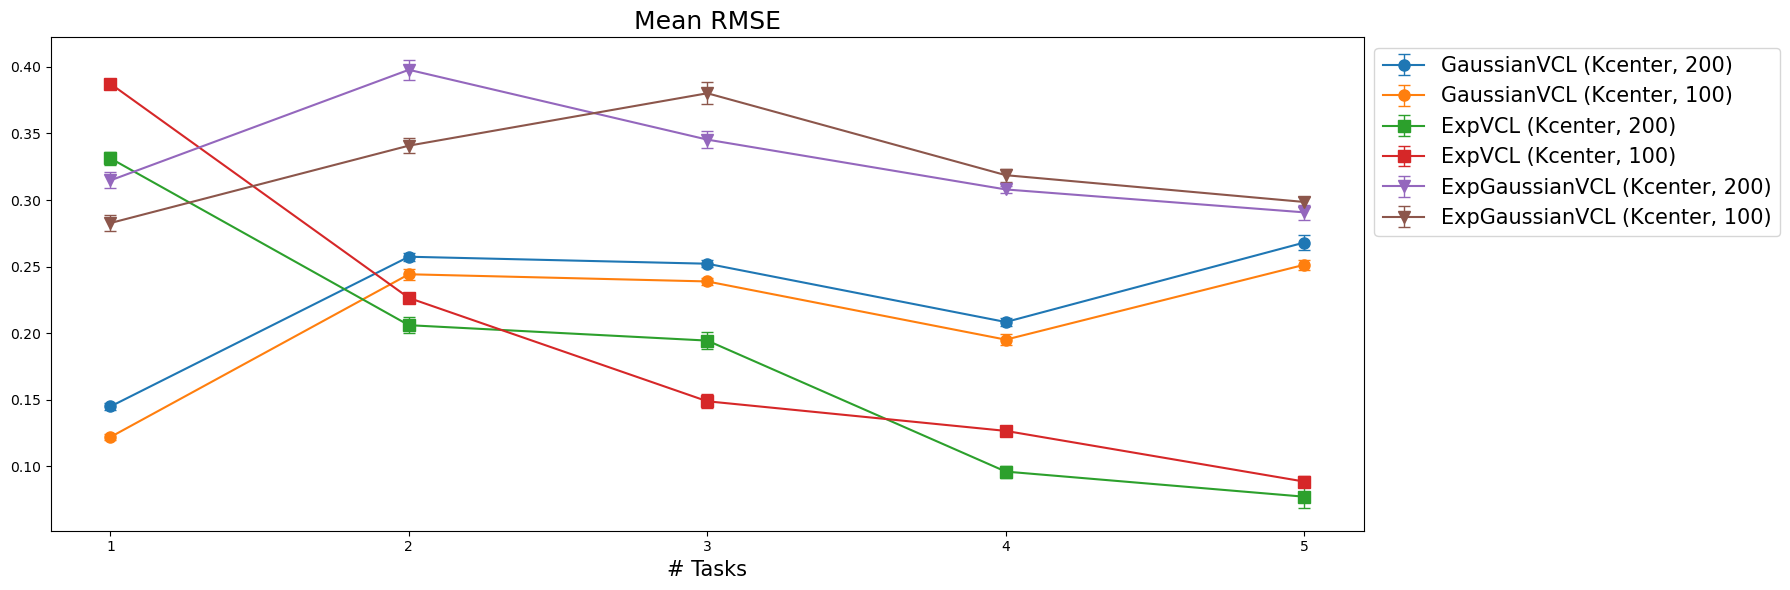

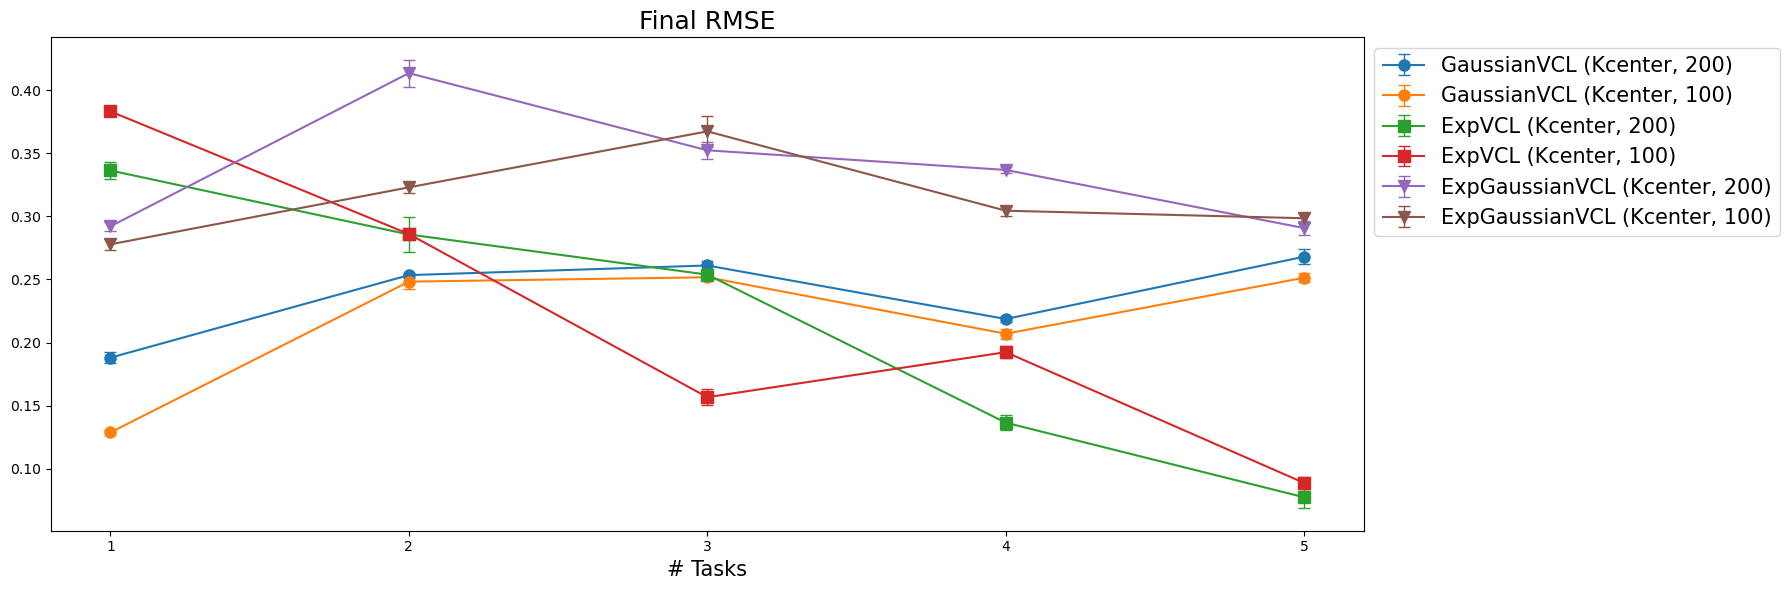

In [348]:
# Compare different coreset sizes for KCenter coreset
plot_mean_results(ExperimentConfig(task_type='regression'), reg_all_results, results_std=reg_all_std,
                 mname_filter=(lambda m : 'None' not in m and m != VANILLA_MODEL and 'K' in m))
plot_final_results(ExperimentConfig(task_type='regression'), reg_all_results, results_std=reg_all_std,
                  mname_filter=(lambda m : 'None' not in m and m != VANILLA_MODEL and 'K' in m))

In [352]:
export_results(cla_all_results, 'classification', datatype='mean')
export_results(cla_all_std, 'classification', datatype='std')
export_results(reg_all_results, 'regression', datatype='mean')
export_results(reg_all_std, 'regression', datatype='std')